In [149]:
import os
from nilearn import datasets, plotting, image
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
import numpy as np
import pandas as pd
import seaborn as sns
import functions as f

In [151]:
def gsr_time_series(img_path_list):
    confounds_minimal_gsr, sample_mask = load_confounds(img_path_list, strategy=["high_pass", "motion", "wm_csf", "global_signal"], motion="basic", wm_csf="basic", global_signal="basic")
    time_series_gsr = []
    for i in range(len(img_path_list)):
        t_r = f.header_t_r(img_path_list[i])
        masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,memory='nilearn_cache', verbose=5, high_pass= 0.01, low_pass=0.08, t_r=t_r, smoothing_fwhm=4)
        time_series_no_gsr_sub = masker.fit_transform(img_path_list[i], confounds=confounds_minimal_gsr[i], sample_mask=sample_mask[i])
        time_series_gsr.append(time_series_no_gsr_sub)
        print(f'{i} / {len(img_path_list)}' )
    return time_series_gsr

def load_time_series():
    root = 'ADNI_full/time_series'
    time_series_list = sorted(os.listdir(root))
    time_series_gsr=[]
    for i in range(len(time_series_list)):
        time_series_sub = np.loadtxt(os.path.join(root, time_series_list[i]), delimiter=',')
        time_series_gsr.append(time_series_sub)
    return time_series_gsr

def df_pcorr(time_series_gsr):
    corr_gsr = []
    for i in range(len(time_series_gsr)):
        df = pd.DataFrame(time_series_gsr[i])
        corr_df = df.corr(method='pearson')
        corr_arr = corr_df.to_numpy()
        corr_arr = np.nan_to_num(corr_arr, nan=0)
        np.fill_diagonal(corr_arr, 0)
        corr_gsr.append(corr_arr)
    return corr_gsr

def plot_corr(corr_mtrx):
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_mtrx, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [116]:
##Generate the atlas used to map the brain
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

##Make dictionary of the positions of the brain segments and the positions in MNI space
#Find the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
seg_pos = {}
for i in range(len(atlas.labels)):
    seg_pos[atlas.labels[i]] = list(np.around(coordinates[i],2))

In [ ]:
#generate the time series of the brain scans
img_path_list = f.filter_file('/Volumes/GPulickal/processed','desc-preproc_bold.nii.gz')
time_series_gsr  = gsr_time_series(img_path_list)
time_series_64 = [i.astype(np.float64) for i in time_series_gsr]
id_list = f.load_patient_info('Subject ID')
f.save_mtrx(time_series_64 , id_list, 'ADNI_full/time_series', 'ts')

[NiftiLabelsMasker.wrapped] loading data from /Users/georgepulickal/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
Resampling labels
[Memory]0.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
0 / 197
[NiftiLabelsMasker.wrapped] loading data from /Users/georgepulickal/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Volumes/GPulickal/processed/sub-ADNI002S0413/ses-M72/func/sub-ADNI002S0413_ses-M72_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x12268e700>, { 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/Users/georgepulickal/nilearn_data/aal_SPM

In [138]:
#load instead of generate
time_series = load_time_series()

In [8]:
#generate correlation matrix from time series
corr_gsr_list = f.df_pcorr(time_series)

[[ 1.          0.67143336  0.31163259 ...  0.05281902 -0.11527818
  -0.29601031]
 [ 0.67143336  1.          0.13337755 ...  0.03842589 -0.10344629
  -0.39284001]
 [ 0.31163259  0.13337755  1.         ... -0.07772465 -0.09019143
  -0.01698834]
 ...
 [ 0.05281902  0.03842589 -0.07772465 ...  1.          0.47267774
  -0.14490358]
 [-0.11527818 -0.10344629 -0.09019143 ...  0.47267774  1.
   0.0258886 ]
 [-0.29601031 -0.39284001 -0.01698834 ... -0.14490358  0.0258886
   1.        ]]


In [146]:
#save correlation matrices
f.save_mtrx(corr_gsr_list , id_list, 'ADNI_full/corr_matrices', 'corr')

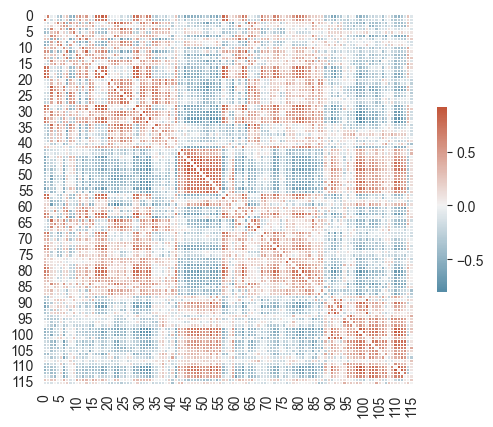

In [155]:
#visualise the correlation graph
plot_corr(corr_gsr_list[20])

In [175]:
#make labels file
labels = f.load_patient_info('Research Group')
np.savetxt('ADNI_full/label_full.csv', labels, fmt='%s', delimiter=",")